In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

In [2]:
%config Completer.use_jedi = False

In [3]:
train = pd.read_csv("/Users/sergmiller/Downloads/train.csv")
edu = pd.read_csv("/Users/sergmiller/Downloads/trainEducationFeatures.csv")
groups =  pd.read_csv("/Users/sergmiller/Downloads/trainGroups.csv")
friends =  pd.read_csv("/Users/sergmiller/Downloads/friends.csv")

In [4]:
np.mean(train['registered_year'])

2013.7580508330789

In [5]:
np.corrcoef(train['registered_year'].values, train['age'].values)

array([[ 1.        , -0.09645648],
       [-0.09645648,  1.        ]])

(array([ 215., 1516., 5647., 3314., 4802., 1981., 3671., 1731., 3629.,
        2963.]),
 array([2006. , 2007.5, 2009. , 2010.5, 2012. , 2013.5, 2015. , 2016.5,
        2018. , 2019.5, 2021. ]),
 <BarContainer object of 10 artists>)

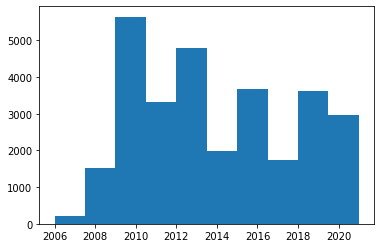

In [6]:
plt.hist(train['registered_year'])

In [7]:
from sklearn.linear_model import LinearRegression

In [158]:
max(train['age'])

89

In [176]:
edu.shape, train.shape

((29469, 9), (29469, 3))

In [8]:
edu_with_register = pd.merge(edu[~pd.isnull(edu['school_education'])], train, how='left', on='uid')

In [9]:
edu_with_register

,uid,school_education,graduation_1,graduation_2,graduation_3,graduation_4,graduation_5,graduation_6,graduation_7,age,registered_year
0,30288,2008.0,NaN,NaN,NaN,NaN,2013.0,NaN,NaN,30,2008
1,25275,2007.0,NaN,NaN,NaN,NaN,NaN,2011.0,NaN,31,2007
2,116156,2008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,2010
3,10794,2006.0,NaN,NaN,NaN,NaN,NaN,NaN,2014.0,34,2010
4,99780,1995.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,2012
...,...,...,...,...,...,...,...,...,...,...,...
9109,90272,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,2012
9110,33331,1987.0,NaN,NaN,NaN,NaN,1991.0,NaN,NaN,51,2008
9111,97581,2002.0,NaN,NaN,NaN,NaN,2007.0,NaN,NaN,36,2010
9112,104038,1969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,2013


In [10]:
edu_with_g5 = pd.merge(edu[~pd.isnull(edu['graduation_5'])], train, how='left', on='uid')

In [11]:
edu_with_g5_and_reg = pd.merge(edu[~pd.isnull(edu['graduation_5'])][~pd.isnull(edu['school_education'])], train, how='left', on='uid')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [419]:
edu_with_g5_and_reg.shape

(1268, 11)

In [420]:
model = LinearRegression()
model.fit(edu_with_g5_and_reg[['registered_year', 'school_education', 'graduation_5']], edu_with_g5_and_reg['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([ 0.06561199, -0.82945563, -0.12746959]), 1821.0781979242786)

In [415]:
model = LinearRegression()
model.fit(edu_with_g5[['registered_year', 'graduation_5']], edu_with_g5['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([ 0.2681817 , -0.89100903]), 1287.6021512433363)

In [184]:
model = LinearRegression()
model.fit(edu_with_register[['registered_year', 'school_education']], edu_with_register['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([-0.05582762, -0.88421684]), 1918.9770112931192)

In [196]:
model = LinearRegression()
model.fit(edu_with_register[['school_education']], edu_with_register['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([-0.88518542]), 1808.6193469773386)

In [105]:
model = LinearRegression()
model.fit(train[['registered_year', 'school']], train['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([-0.32882735]), 697.2078772973922)

In [ ]:
model.predict()

In [12]:
def decision(school: float, register: float, groups: list):
    if np.isnan(school):
        r = 697.208 - 0.32883 * register  # approx 35
    else:
#         r = 2021 - school + 18
        r = 1918.977 - 0.05583 * register - 0.88422 * school
#         r = 1808.62 - 0.88519 * school
    r = max(r, 14)
    r = min(89, r)
    return r


def make_predictions(ids: pd.DataFrame, education: pd.DataFrame, groups: pd.DataFrame) -> pd.DataFrame:
    result = pd.DataFrame()
    result['uid'] = ids['uid']
    school = {uid : year for uid, year in zip(education['uid'].values, education['school_education'].values)}
    register = {uid : year for uid, year in zip(ids['uid'].values, ids['registered_year'].values)}
    groups_list = defaultdict(list)
    for uid, gid in zip(groups['uid'].values, groups['gid'].values):
        groups_list[uid].append(gid)
    result['age'] = [decision(school[uid], register[uid], groups_list[uid]) for uid in result['uid'].values]
    assert result.shape[0] == ids.shape[0] and result.shape[1] == 2
    assert ['uid', 'age'] == list(result.columns)
    return result

In [364]:
res = make_predictions(train, edu, groups)

In [360]:
np.mean((res['age'] - train['age']) ** 2) ** 0.5

11.541098370410738

In [19]:
result.to_csv('/Users/sergmiller/Downloads/result.csv', index=None, index_label=None)

In [23]:
np.mean(train['age'].values)

35.02914927550986

In [17]:
list(result.columns)

['uid', 'age']

In [ ]:
np.mean(train['age'].values)

In [13]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

In [14]:
user_weights = groups.groupby('uid').gid.nunique()
user2weight = {u:w for u,w in zip(user_weights.index.values, user_weights.values)}

In [772]:
row = groups['gid'].values
col = groups['uid'].values
# data = [user2weight[u] for u in col]
data_group_age = [uid2age[u] for u in col]

(array([1.784e+03, 1.130e+03, 8.550e+02, 7.280e+02, 7.080e+02, 6.500e+02,
        6.140e+02, 5.250e+02, 5.000e+02, 5.270e+02, 4.330e+02, 4.150e+02,
        2.970e+02, 4.240e+02, 3.910e+02, 3.470e+02, 3.270e+02, 3.050e+02,
        2.900e+02, 3.050e+02, 2.970e+02, 3.000e+02, 2.530e+02, 2.820e+02,
        1.690e+02, 2.260e+02, 2.400e+02, 2.170e+02, 2.520e+02, 2.020e+02,
        1.840e+02, 1.850e+02, 2.000e+02, 6.029e+03, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   3.92,   6.84,   9.76,  12.68,  15.6 ,  18.52,  21.44,
         24.36,  27.28,  30.2 ,  33.12,  36.04,  38.96,  41.88,  44.8 ,
         47.72,  50.64,  53.56,  56.48,  59.4 ,  62.32,  65.24,  68.16,
         71.08,  74.  ,  76.92,  79.84,  82.76,  85.68,  88.6 ,  91.52,
         94.44,  97.36, 100.28, 103.2 , 106.12, 109.04, 111.96, 114.88,
        117.8 , 

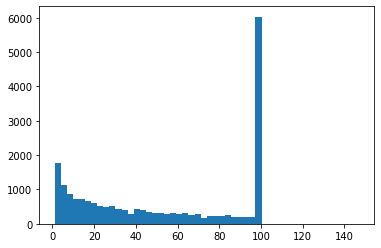

In [16]:
plt.hist(user_weights.values, bins=50)

In [17]:
max(row), max(col)

(362032, 120055)

In [18]:
train_g2u = csr_matrix((data, (row, col)), shape=(362033, 120056))

In [773]:
train_g2u_age = csr_matrix((data_group_age, (row, col)), shape=(362033, 120056))

In [19]:
als = AlternatingLeastSquares(factors=32, random_state=0)
als.fit(train_g2u)

  0%|          | 0/15 [00:00<?, ?it/s]

In [774]:
als_group_age = AlternatingLeastSquares(factors=32, random_state=0)
als_group_age.fit(train_g2u_age)

  0%|          | 0/15 [00:00<?, ?it/s]

In [308]:
als.item_factors.shape

(362033, 32)

In [309]:
als.user_factors.shape

(120056, 32)

In [20]:
from sklearn.neighbors import KNeighborsRegressor

In [777]:
N = 10000

In [775]:
user_embs_for_knn_als_group_age = np.array([als_group_age.user_factors[u] for u in train['uid'].values])
knn_age = train['age'].values
user_embs_for_knn_als_group_age.shape, knn_age.shape

((29469, 32), (29469,))

In [21]:
def calc_embedding_by_user_groups(user_groups: np.array):
    groups_embeds = als.item_factors[user_groups]
    user_embed = np.mean(groups_embeds, axis=0)
    return user_embed

In [351]:
%%time
for x in user_embs_for_knn[N:]:
    print(float(knn.predict([x])))
    break

31.426724404225716
CPU times: user 6.27 ms, sys: 2.66 ms, total: 8.93 ms
Wall time: 2.73 ms


In [779]:
%%time
knn = KNeighborsRegressor(weights='distance', n_neighbors=25)
knn.fit(user_embs_for_knn_als_group_age, knn_age)

knn_age_predicted = knn.predict(user_embs_for_knn_als_group_age)

res = np.mean((knn_age_predicted - knn_age) ** 2) ** 0.5
res

CPU times: user 29.2 s, sys: 6.57 s, total: 35.8 s
Wall time: 17.5 s


7.739072997473664

In [778]:
%%time
knn = KNeighborsRegressor(weights='distance', n_neighbors=25)
knn.fit(user_embs_for_knn_als_group_age[:N], knn_age[:N])

knn_age_predicted = knn.predict(user_embs_for_knn_als_group_age[N:])

res = np.mean((knn_age_predicted - knn_age[N:]) ** 2) ** 0.5
res

CPU times: user 6.6 s, sys: 1.83 s, total: 8.43 s
Wall time: 4.07 s


10.741940886753522

In [348]:
pd.read_csv('../submision/data/train_groups.csv').values.shape

(160831, 1)

In [326]:
known_groups = np.unique(groups['gid'].values)

In [329]:
pd.DataFrame(known_groups).to_csv("../submision/data/train_groups.csv", index=None, index_label=None)

In [330]:
user_embs_for_knn.shape

(29469, 32)

In [331]:
train['uid'].shape

(29469,)

In [332]:
pd.DataFrame(train).to_csv("../submision/data/train.csv", index=None, index_label=None)

In [336]:
pd.DataFrame(user_embs_for_knn).to_csv("../submision/data/train_als_user_embeddings.csv", index=None, index_label=None)

In [340]:
group_embds_for_knn = als.item_factors[known_groups]

In [341]:
group_embds_for_knn.shape

(160831, 32)

In [339]:
user_embs_for_knn.shape

(29469, 32)

In [342]:
pd.DataFrame(group_embds_for_knn).to_csv("../submision/data/train_als_group_embeddings.csv", index=None, index_label=None)

In [345]:
als.item_factors[[1,2]]

array([[-0.03352285,  0.01173679, -0.00479133, -0.00079793,  0.00691519,
         0.02763588, -0.00387738, -0.02486044, -0.00412413, -0.01828809,
         0.03304713,  0.00094347,  0.03785113, -0.00548973,  0.00034857,
        -0.02208665,  0.00284895,  0.03267703, -0.00689618,  0.02914728,
         0.01545629,  0.01312421,  0.01298617,  0.01491231, -0.01607238,
        -0.00461709, -0.00313677,  0.00893403,  0.01912749,  0.04901997,
        -0.00721672,  0.02671472],
       [ 0.01577521, -0.00342512, -0.03403663, -0.00619824, -0.01844874,
         0.02002376, -0.01083123, -0.01982027, -0.02211998,  0.02357365,
         0.02775149,  0.00207958,  0.00818852,  0.0136739 ,  0.01661555,
         0.00561788, -0.01665961, -0.01122996, -0.00927404, -0.0091855 ,
         0.01583714,  0.01119312,  0.01644872, -0.00017456,  0.01745618,
         0.00827894,  0.00624486,  0.00029817,  0.00274924,  0.02194361,
         0.00729352,  0.02449917]], dtype=float32)

In [368]:
pd.read_csv('../submision/data/train_als_user_embeddings.csv').values

array([[ 0.00620317,  0.01065773, -0.01442813, ...,  0.02823488,
         0.02111417,  0.0143768 ],
       [ 0.6269256 , -0.19519456,  0.26703796, ...,  0.19338019,
         0.8778059 , -0.30893627],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02584702,  0.06221347, -0.00454262, ...,  0.01528523,
         0.01898878,  0.09596544],
       [-0.5718822 ,  0.6594821 ,  0.07554404, ..., -1.6461611 ,
         0.64993376, -1.061764  ]])

In [22]:
friends2way = pd.DataFrame()
friends2way['uid'] = list(friends['uid']) + list(friends['fuid'])
friends2way['fuid'] = list(friends['fuid']) + list(friends['uid'])

In [23]:
friends2way.shape

(8219754, 2)

In [24]:
friend_weights = friends2way.groupby('uid').fuid.nunique()
friend2weight = {u:w for u,w in zip(friend_weights.index.values, friend_weights.values)}

In [25]:
rowf = friends2way['fuid'].values
colf = friends2way['uid'].values
dataf = [friend2weight[u] for u in colf]

(array([7.1364e+04, 2.3933e+04, 1.0380e+04, 2.4480e+03, 6.8500e+02,
        3.7100e+02, 2.3300e+02, 2.0600e+02, 1.2700e+02, 9.4000e+01,
        7.8000e+01, 7.3000e+01, 5.8000e+01, 4.5000e+01, 4.2000e+01,
        2.8000e+01, 2.4000e+01, 2.2000e+01, 1.4000e+01, 1.2000e+01,
        2.1000e+01, 7.0000e+00, 1.0000e+01, 1.0000e+01, 1.0000e+01,
        7.0000e+00, 3.0000e+00, 6.0000e+00, 5.0000e+00, 4.0000e+00,
        3.0000e+00, 3.0000e+00, 5.0000e+00, 2.0000e+00, 1.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([1.00000e+00, 5.55200e+01, 1.10040e+02, 1.64560e+02, 2.19080e+02,
        2.73600e+02, 3.28120e+02, 3.82640e+02, 4.37160e+02, 4.91680e+02,
        5.46200e+02, 6.00720e+02, 6.55240e+02, 7.09760e+02, 7.64280e+02,
        8.18800e+02, 8.73320e+02, 9.27840e+02, 9.82360e+02, 1.03688e+03,
        1.09140e+03, 1.145

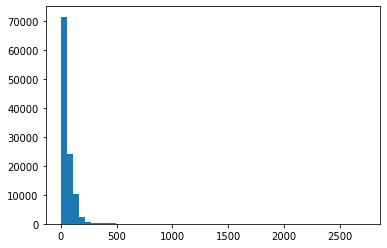

In [26]:
plt.hist(friend_weights.values, bins=50)

In [27]:
max(rowf), max(colf)

(120060, 120060)

In [28]:
train_f2u = csr_matrix((dataf, (rowf, colf)), shape=(120061, 120061))

In [732]:
train_f2u_w1 = csr_matrix((np.ones_like(dataf), (rowf, colf)), shape=(120061, 120061))

In [592]:
friends_als = AlternatingLeastSquares(factors=16, random_state=0)  # was 16
friends_als.fit(train_f2u)

  0%|          | 0/15 [00:00<?, ?it/s]

In [922]:
als.item_factors.shape

(362033, 32)

In [921]:
#group_als_all_user_embeddings.csv
pd.DataFrame(als.user_factors).to_csv("../submision/data/group_als_all_user_embeddings.csv", index=None, index_label=None)

In [549]:
als.user_factors.shape

(120056, 32)

In [396]:
from sklearn.neighbors import KNeighborsRegressor

In [397]:
N = 10000

In [398]:
user_embs_for_knn = np.array([als.user_factors[u] for u in train['uid'].values])
knn_age = train['age'].values
user_embs_for_knn.shape, knn_age.shape

((29469, 16), (29469,))

In [399]:
def calc_embedding_by_user_friends(user_friends: np.array):
    groups_embeds = als.item_factors[user_friends]
    user_embed = np.mean(groups_embeds, axis=0)
    return user_embed

In [351]:
%%time
for x in user_embs_for_knn[N:]:
    print(float(knn.predict([x])))
    break

31.426724404225716
CPU times: user 6.27 ms, sys: 2.66 ms, total: 8.93 ms
Wall time: 2.73 ms


In [400]:
%%time
knn = KNeighborsRegressor(weights='distance', n_neighbors=25)
knn.fit(user_embs_for_knn, knn_age)

knn_age_predicted = knn.predict(user_embs_for_knn)

res = np.mean((knn_age_predicted - knn_age) ** 2) ** 0.5
res

CPU times: user 29.5 s, sys: 6.69 s, total: 36.1 s
Wall time: 17.5 s


4.1398631323867425

In [403]:
%%time

for ng in [5,10,15,20,25,50,100]:
    knn = KNeighborsRegressor(weights='distance', n_neighbors=ng)
    knn.fit(user_embs_for_knn[:N], knn_age[:N])

    knn_age_predicted = knn.predict(user_embs_for_knn[N:])

    res = np.mean((knn_age_predicted - knn_age[N:]) ** 2) ** 0.5
    print(ng, res)

5 10.627967069866244
10 10.174975948579815
15 10.13221329894644
20 10.093566655497026
25 10.090185866004456
50 10.145900310413072
100 10.230385974242639
CPU times: user 49.6 s, sys: 12.6 s, total: 1min 2s
Wall time: 31.3 s


In [134]:
known_friends = np.unique(friends2way['uid'].values)

In [405]:
pd.DataFrame(known_friends).to_csv("../submision/data/train_friends.csv", index=None, index_label=None)

In [591]:
friends_train_user_embs_for_knn.shape, friends_user_embds_for_knn.shape

((29469, 8), (110352, 8))

In [593]:
friends_train_user_embs_for_knn = np.array([friends_als.user_factors[u] for u in train['uid'].values])
friends_user_embds_for_knn = friends_als.item_factors[known_friends]

In [594]:
pd.DataFrame(friends_train_user_embs_for_knn).to_csv("../submision/data/train_friends_als_user_embeddings.csv", index=None, index_label=None)
pd.DataFrame(friends_user_embds_for_knn).to_csv("../submision/data/friends_als_user_embeddings.csv", index=None, index_label=None)

In [910]:
pd.DataFrame(friends_als.user_factors).to_csv("../submision/data/friends_als_all_user_embeddings.csv", index=None, index_label=None)

In [595]:
friends_embds_for_knn = friends_als.item_factors[known_friends]

In [596]:
pd.DataFrame(friends_embds_for_knn).to_csv("../submision/data/train_friends_als_friends_embeddings.csv", index=None, index_label=None)

In [145]:
from sklearn.neural_network import MLPRegressor

In [31]:
uid2age =  {u:a for u,a in zip (train['uid'].values, train['age'].values)}

In [36]:
from fast_pagerank import pagerank_power

In [42]:
friend_pr=pagerank_power(train_f2u, p=0.85, tol=1e-3)

In [43]:
friend_pr

array([3.27044627e-06, 2.52198502e-05, 1.34158138e-06, ...,
       1.38165961e-06, 1.34158138e-06, 1.59154157e-05])

In [780]:
friend_pr_v2 = pagerank_power(train_f2u, p=0.1, tol=1e-3)

In [781]:
friend_pr_v2

array([7.74463918e-06, 9.80807013e-06, 7.55730325e-06, ...,
       7.57879466e-06, 7.55730325e-06, 9.87380830e-06])

In [99]:
friends_list = defaultdict(list)
for uid, fuid in zip(friends['uid'].values, friends['fuid'].values):
    friends_list[uid].append(fuid)
    friends_list[fuid].append(uid)

In [128]:
f_cache = {}
def get_friends_mean_embed(uid):
    if uid in f_cache:
        return f_cache[uid]
    e = np.zeros(16)
    f_list = friends_list[uid]
    if len(f_list) == 0:
        return e
    for f in f_list:
        e += friends_als.user_factors[f]
    r = e / len(f_list)
    f_cache[uid] = r
    return r

In [150]:
def decision_naive_impl(school: float, register: float, g5: float) -> float:
    if np.isnan(school):
        if np.isnan(g5):
            r = 697.208 - 0.32883 * register  # LM approx 35
        else:
            r = 1287.602 + 0.26818 * register - 0.89101 * g5  # LM approx register and graduation_5
    else:
        if np.isnan(g5):
            r = 1918.977 - 0.05583 * register - 0.88422 * school  # LM approx 2021 - school + 18 + Residual(register)
        else:
            r = 1821.079 + 0.06561 * register - 0.82946 * school - 0.12747 * g5  # LM approx all available params
    r = max(14, r)
    r = min(89, r)
    return r

In [193]:
import networkx as nx

In [195]:
g = nx.Graph()

for st in friends_list.keys():
    for fn in friends_list[st]:
        g.add_edge(st, fn)

In [197]:
numNodes = len(g.nodes)
numNodes

110352

In [228]:
import networkx as nx
import numpy as np
import scipy
from scipy.sparse import csgraph

numNodes = len(g.nodes)
degreeHist = nx.degree_histogram(g)
degreeKernel = [x/numNodes for x in degreeHist]

In [218]:
A = nx.convert_matrix.to_scipy_sparse_matrix(g)

In [597]:
G_H = 2 + 16
X = np.zeros((110352, G_H))

id2node = {_id: i for i, _id in enumerate(list(g.nodes))}

for i,uid in enumerate(list(g.nodes)):
    X[i] = [
        friend2weight.get(uid, 0),
#         user2weight.get(uid, 0),
        friend_pr[uid]
    ] + list(friends_als.user_factors[uid])

In [598]:
np.random.seed(0)
G_DIM = 64
W0 = np.random.normal(size=(G_H, G_DIM)) / (G_DIM ** 0.5)
W1 = np.random.normal(size=(G_H + G_DIM, G_DIM)) / ((G_H + G_DIM) ** 0.5)
W2 = np.random.normal(size=(G_H + 2 * G_DIM, G_DIM)) / ((G_H + 2 * G_DIM) ** 0.5)
W3 = np.random.normal(size=(G_H + 3 * G_DIM, G_DIM)) / ((G_H + 3 * G_DIM) ** 0.5)

np.mean(np.sum(W0,axis=1)),np.mean(np.sum(W1,axis=1)),np.mean(np.sum(W2,axis=1)),np.mean(np.sum(W3,axis=1))

(-0.27144582958536595,
 -0.07314975974646727,
 -0.03288278916306396,
 0.012127650685856618)

In [599]:
D = scipy.sparse.csgraph.laplacian(A, normed=True)
# слой 0
Xc = D @ X @ W0
# ReLU
Xc = Xc * (Xc>0)
# конкатенация признаков вершин с аггрегированной информацией соседей
Xn = np.hstack((X, Xc))
# слой 1
Xc = D @ Xn @ W1
# ReLU
Xc = Xc * (Xc>0)
Xn = np.hstack((Xn, Xc))
# слой 2
Xc = D @ Xn @ W2

# Xc = Xc * (Xc>0)
# Xn = np.hstack((Xn, Xc))
# # слой 3
# Xc = D @ Xn @ W3

embedding = Xc / np.abs(Xc).sum(axis=1, keepdims=True)

In [600]:
from sklearn.decomposition import PCA

In [792]:
from sklearn.cluster import KMeans

In [813]:
kmeans = KMeans(n_clusters=8)

In [814]:
clusters = kmeans.fit_predict(embedding)

In [815]:
clusters

array([7, 7, 3, ..., 1, 1, 7], dtype=int32)

In [601]:
pca = PCA(2)
proj = pca.fit_transform(embedding)
# proj = pca.fit_transform(friends_als.user_factors)

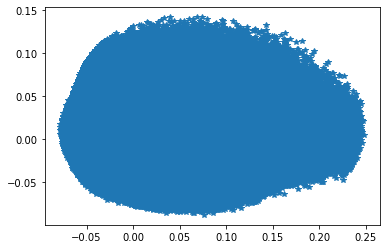

In [602]:
plt.plot(proj[:, 0], proj[:, 1], '*')
plt.show()

In [603]:
pd.DataFrame(list(g.nodes)).to_csv('../submision/data/graph_nodes_user_ids.csv', index=None, index_label=None)
pd.DataFrame(embedding).to_csv('../submision/data/graph_embeddings.csv', index=None, index_label=None)

In [604]:
uid2gembeddding = {uid: embedding[i] for i, uid in enumerate(list(g.nodes))}

In [797]:
uid2kmeans = {uid: clusters[i] for i, uid in enumerate(list(g.nodes))}

In [476]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [479]:
gem_train, gem_test, y_age_train, y_age_test = train_test_split(
    [uid2gembeddding.get(u, np.zeros(G_DIM)) for u in train['uid'].values],
    train['age'].values, random_state=0)

In [514]:
import catboost

In [521]:
model = catboost.CatBoostRegressor(random_state=0)

In [522]:
model.fit(gem_train, y_age_train, eval_set=(gem_test, y_age_test))

Learning rate set to 0.082714
0:	learn: 12.9822743	test: 13.0701603	best: 13.0701603 (0)	total: 15.8ms	remaining: 15.8s
1:	learn: 12.8789326	test: 12.9662190	best: 12.9662190 (1)	total: 23.1ms	remaining: 11.5s
2:	learn: 12.7920005	test: 12.8798984	best: 12.8798984 (2)	total: 30.4ms	remaining: 10.1s
3:	learn: 12.7118519	test: 12.7984151	best: 12.7984151 (3)	total: 39.2ms	remaining: 9.77s
4:	learn: 12.6388049	test: 12.7254235	best: 12.7254235 (4)	total: 46ms	remaining: 9.16s
5:	learn: 12.5657296	test: 12.6550436	best: 12.6550436 (5)	total: 52.6ms	remaining: 8.72s
6:	learn: 12.4896408	test: 12.5786277	best: 12.5786277 (6)	total: 62.5ms	remaining: 8.86s
7:	learn: 12.4305087	test: 12.5200338	best: 12.5200338 (7)	total: 68.5ms	remaining: 8.49s
8:	learn: 12.3676977	test: 12.4587991	best: 12.4587991 (8)	total: 75ms	remaining: 8.26s
9:	learn: 12.3051146	test: 12.3999576	best: 12.3999576 (9)	total: 81.6ms	remaining: 8.08s
10:	learn: 12.2533129	test: 12.3435948	best: 12.3435948 (10)	total: 88.4ms

In [523]:
pseudo_label = model.predict(embedding)

In [525]:
pseudo_model = catboost.CatBoostRegressor(random_state=0)
pseudo_model.fit(embedding, pseudo_label)

Learning rate set to 0.09016
0:	learn: 7.8609248	total: 21.4ms	remaining: 21.4s
1:	learn: 7.6478520	total: 36.1ms	remaining: 18s
2:	learn: 7.4648554	total: 50.3ms	remaining: 16.7s
3:	learn: 7.2846605	total: 62.7ms	remaining: 15.6s
4:	learn: 7.1226710	total: 73.6ms	remaining: 14.6s
5:	learn: 6.9766454	total: 84.3ms	remaining: 14s
6:	learn: 6.8373638	total: 98.2ms	remaining: 13.9s
7:	learn: 6.6881187	total: 112ms	remaining: 13.9s
8:	learn: 6.5732778	total: 124ms	remaining: 13.7s
9:	learn: 6.4472321	total: 140ms	remaining: 13.8s
10:	learn: 6.3426685	total: 155ms	remaining: 13.9s
11:	learn: 6.2432753	total: 170ms	remaining: 14s
12:	learn: 6.1385079	total: 186ms	remaining: 14.1s
13:	learn: 6.0635830	total: 196ms	remaining: 13.8s
14:	learn: 5.9811684	total: 208ms	remaining: 13.7s
15:	learn: 5.9074319	total: 220ms	remaining: 13.5s
16:	learn: 5.8307625	total: 234ms	remaining: 13.5s
17:	learn: 5.7637772	total: 244ms	remaining: 13.3s
18:	learn: 5.6961353	total: 257ms	remaining: 13.3s
19:	learn: 

In [526]:
meta_pseudo = pseudo_model.predict(embedding)

In [527]:
uid2meta_pseudo = {uid: meta_pseudo[i] for i, uid in enumerate(list(g.nodes))}

In [533]:
pd.DataFrame(meta_pseudo).to_csv('../submision/data/meta_pseudo.csv', index=None, index_label=None)

In [967]:
edu_features = []
edu_ids = edu['uid']
edu_ages = np.array([uid2age[u] for u in edu_ids])
uid2register = {u:r for u,r in zip(train['uid'].values, train['registered_year'].values)}
for x in edu.iterrows():
    x = x[1]
    uid = int(x['uid'])
    get_2000 = lambda name: x[name] - 2000 if not np.isnan(x[name]) else 0
    make_ind = lambda name: int(np.isnan(x[name]))
    features_ind = [make_ind('school_education')]
    for i in range(1, 8):
        features_ind.append(make_ind('graduation_{}'.format(i)))
    features = [get_2000('school_education')]
    for i in range(1, 8):
        features.append(get_2000('graduation_{}'.format(i)))
    register_year = uid2register[uid]
    
    features.append(friend2weight.get(uid, 0))
    features.append(user2weight.get(uid, 0))

    features.append(friend_pr[uid])
    #features.append(friend_pr_v2[uid])
    #features.append(uid2kmeans.get(uid,-1))

    features.append(register_year)
    features.append(uid2mmg.get(uid, 35))
    features.append(uid2mmf.get(uid, 35))
    features.append(uid2mmg_reg.get(uid, 2014))
    features.append(uid2mmf_reg.get(uid, 2014))
#     features.append(uid2meta_pseudo.get(uid, 0))
#     features.append(decision_naive_impl(x['school_education'], register_year, x['graduation_5']))
    f = features_ind + features  + list(uid2gembeddding.get(uid, np.zeros(G_DIM))) + list(friends_als.user_factors[uid])# + list(als.user_factors[uid])
    # + list(get_friends_mean_embed(uid))
#     f += list(uid2gembeddding.get(uid, np.zeros(16)))
    edu_features.append(f)

In [946]:
np.mean(friends_als.item_factors,axis=0)

array([0.00207183, 0.00355059, 0.00283433, 0.00150549, 0.00308064,
       0.00168812, 0.00260866, 0.00268273, 0.00192601, 0.00249572,
       0.00152326, 0.00334434, 0.00246569, 0.00300442, 0.00339367,
       0.00160724], dtype=float32)

In [944]:
np.mean(als.item_factors,axis=0)

array([0.00244036, 0.00203669, 0.00181023, 0.00288724, 0.00168105,
       0.00253628, 0.0019611 , 0.00245336, 0.00279846, 0.00175673,
       0.00231933, 0.00180845, 0.00269746, 0.00226039, 0.00224252,
       0.00202341, 0.00218132, 0.00209919, 0.00211487, 0.00196292,
       0.00131669, 0.00241805, 0.00255356, 0.0026769 , 0.00232002,
       0.00262157, 0.00175571, 0.00160803, 0.00271791, 0.0023224 ,
       0.00258682, 0.0021744 ], dtype=float32)

In [968]:
GROUP_ALS_DIM = 32
FRIEND_ALS_DIM = 16
GEMBEDDINGS_DIM = G_DIM
ALS_TRAIN_GROUPS_TH = 1  # 5 is worse that 1
GROUP_OVER_FRIEND_WEIGHT = 0.75
ALS_OVER_NAIVE_WEIGHT = 0.5
# NAIVE_OVER_CB_WEIGHT = 0
# FRIEND_ALS_OVER_CB_WEIGHT = 0
FULL_ALS_OVER_CB_WEIGHT = 0.5

COMMON_SLICE_LEN = 8 + 8 + 2 + 1 + 5
FORBIDEN_TAIL_OF_COMMON_SLICE_LEN = 5
CB_V1_FEATURE_SLICE = list(np.arange(COMMON_SLICE_LEN + GEMBEDDINGS_DIM + FRIEND_ALS_DIM))# + GROUP_ALS_DIM))
# CB_V1_5_FEATURE_SLICE = CB_V1_FEATURE_SLICE + list(np.arange(FRIEND_ALS_DIM) + COMMON_SLICE_LEN + GEMBEDDINGS_DIM)
# CB_V2_FEATURE_SLICE = list(np.arange(COMMON_SLICE_LEN - FORBIDEN_TAIL_OF_COMMON_SLICE_LEN)) + list(np.arange(FRIEND_ALS_DIM) + COMMON_SLICE_LEN + GEMBEDDINGS_DIM)
# CB_V3_FEATURE_SLICE = CB_V2_FEATURE_SLICE + list(np.arange(GROUP_ALS_DIM) + COMMON_SLICE_LEN + GEMBEDDINGS_DIM + FRIEND_ALS_DIM)

In [953]:
len(CB_V1_FEATURE_SLICE)

104

In [957]:
len(edu_features[0]), 8 + 8 + 2 + 1 +5 + 64 + 16

(104, 104)

In [904]:
import catboost

In [969]:
edu_features = np.array(edu_features)
M = len(edu_features)
ids = np.arange(M)
np.random.seed(0)
np.random.shuffle(ids)
K = 25000
train_ids = ids[:K]
val_ids = ids[K:]
print(train_ids, val_ids, K, M)
print(ids)

[ 5323  2124 13065 ... 24015  9191 14056] [ 3836  8618  7370 ...  9845 10799  2732] 25000 29469
[ 5323  2124 13065 ...  9845 10799  2732]


In [585]:
edu_features.shape

(29469, 124)

In [311]:
%%time
model1 = catboost.CatBoostRegressor(random_state=0)
model1.fit(edu_features[train_ids, :CB_V1_FEATURE_COUNT], edu_ages[train_ids],
           eval_set=(edu_features[val_ids, :CB_V1_FEATURE_COUNT], edu_ages[val_ids]))

model1.save_model("../submision/data/edu_v1_g_y_lm.cbm")

Learning rate set to 0.084664
0:	learn: 12.8496424	test: 12.8855423	best: 12.8855423 (0)	total: 12.9ms	remaining: 12.9s
1:	learn: 12.6050754	test: 12.6323468	best: 12.6323468 (1)	total: 21.4ms	remaining: 10.7s
2:	learn: 12.4054276	test: 12.4218397	best: 12.4218397 (2)	total: 28.5ms	remaining: 9.47s
3:	learn: 12.2225137	test: 12.2342569	best: 12.2342569 (3)	total: 33.8ms	remaining: 8.41s
4:	learn: 12.0466931	test: 12.0560889	best: 12.0560889 (4)	total: 39.7ms	remaining: 7.9s
5:	learn: 11.9018582	test: 11.9087901	best: 11.9087901 (5)	total: 44.7ms	remaining: 7.4s
6:	learn: 11.7699150	test: 11.7755872	best: 11.7755872 (6)	total: 50.3ms	remaining: 7.14s
7:	learn: 11.6672710	test: 11.6644378	best: 11.6644378 (7)	total: 55.3ms	remaining: 6.85s
8:	learn: 11.5617318	test: 11.5572354	best: 11.5572354 (8)	total: 61.4ms	remaining: 6.76s
9:	learn: 11.4643390	test: 11.4656300	best: 11.4656300 (9)	total: 65.8ms	remaining: 6.51s
10:	learn: 11.3842180	test: 11.3841047	best: 11.3841047 (10)	total: 71.4

In [368]:
len(CB_V3_FEATURE_SLICE)

67

In [971]:
NUM_MODELS = 10
SPLIT_RATIO = 0.1
SPLIT_SIZE = int(SPLIT_RATIO * len(edu_features))

for i in range(NUM_MODELS):
    _ids = np.arange(len(edu_features))
    np.random.seed(i)
    np.random.shuffle(_ids)
    val_part = _ids[:SPLIT_SIZE]
    train_part = _ids[SPLIT_SIZE:]
    train_X = edu_features[train_part][:, CB_V1_FEATURE_SLICE]
    train_y = edu_ages[train_part]
    val_X = edu_features[val_part][:, CB_V1_FEATURE_SLICE]
    val_y = edu_ages[val_part]

    model = catboost.CatBoostRegressor(random_state=0, max_bin=32)
    model.fit(train_X, train_y, eval_set=(val_X, val_y))
    model.save_model("../submision/data/edu_v1_g_y_mmg_mmf_mmgreg_mmfreg_p35_a10_part_bins32_v2_{}_of_{}.cbm".format(i+1, NUM_MODELS))

Learning rate set to 0.085615
0:	learn: 12.4797619	test: 12.3713651	best: 12.3713651 (0)	total: 9.46ms	remaining: 9.46s
1:	learn: 11.8910726	test: 11.7787603	best: 11.7787603 (1)	total: 16.8ms	remaining: 8.38s
2:	learn: 11.3541699	test: 11.2475940	best: 11.2475940 (2)	total: 27.2ms	remaining: 9.05s
3:	learn: 10.8792128	test: 10.7651247	best: 10.7651247 (3)	total: 36.2ms	remaining: 9.01s
4:	learn: 10.4420389	test: 10.3290307	best: 10.3290307 (4)	total: 43ms	remaining: 8.55s
5:	learn: 10.0569383	test: 9.9485644	best: 9.9485644 (5)	total: 50.2ms	remaining: 8.31s
6:	learn: 9.7380167	test: 9.6339739	best: 9.6339739 (6)	total: 58.4ms	remaining: 8.28s
7:	learn: 9.4273282	test: 9.3208919	best: 9.3208919 (7)	total: 66.8ms	remaining: 8.28s
8:	learn: 9.1686697	test: 9.0613637	best: 9.0613637 (8)	total: 74.5ms	remaining: 8.2s
9:	learn: 8.9294567	test: 8.8234288	best: 8.8234288 (9)	total: 80.4ms	remaining: 7.96s
10:	learn: 8.7160575	test: 8.6068812	best: 8.6068812 (10)	total: 88.2ms	remaining: 7.93

In [972]:
2 + 2

4

In [749]:
model.get_borders()

{0: [0.5],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [0.5],
 6: [],
 7: [],
 8: [-27.5,
  -23.5,
  -19.5,
  -16.5,
  -14.5,
  -12.5,
  -10.5,
  -9.5,
  -8.5,
  -6.5,
  -4.5,
  -3.5,
  -2.5,
  -1.5,
  -0.5,
  0.5,
  1.5,
  2.5,
  3.5,
  4.5,
  5.5,
  6.5,
  7.5,
  8.5,
  9.5,
  11.5,
  12.5,
  13.5,
  15.5,
  18.5,
  21.5],
 9: [10.5, 11.5, 12.5],
 10: [-21.5, -17.5, -14.5, -5.5, -1.0, 5.5, 24.5],
 11: [-5.5, 15.5, 18.5, 26.5],
 12: [20.5],
 13: [-23.5,
  -20.5,
  -18.5,
  -16.5,
  -15.5,
  -11.5,
  -9.5,
  -6.5,
  -4.5,
  -3.5,
  -2.5,
  -1.5,
  -0.5,
  3.5,
  4.5,
  5.5,
  12.5,
  13.5,
  14.5],
 14: [-11.0, -3.5, -2.5, -0.5, 11.5, 18.5],
 15: [-15.5, -10.5, -8.5, 19.5],
 16: [0.5,
  1.5,
  2.5,
  3.5,
  4.5,
  6.5,
  8.5,
  10.5,
  12.5,
  14.5,
  15.5,
  17.5,
  20.5,
  23.5,
  35.5,
  48.5,
  59.5,
  111.5,
  178.5],
 17: [0.5, 1.5, 2.5, 3.5, 4.5, 9.5, 12.5, 15.5, 20.5, 37.5],
 18: [1.3416879482974764e-06,
  1.3443067246043938e-06,
  1.3509659311239375e-06,
  1.3651608696818585e-06,
  1.

In [970]:
model1 = catboost.CatBoostRegressor(random_state=0, max_bin=32)
model1.fit(catboost.Pool(data=edu_features[train_ids][:, CB_V1_FEATURE_SLICE], label=edu_ages[train_ids]),
           eval_set=catboost.Pool(data=edu_features[val_ids][:, CB_V1_FEATURE_SLICE], label=edu_ages[val_ids]))

model1.save_model("../submision/data/edu_v1_g_y_mmg_mmf_mmgreg_mmfreg_p35_a10_bins32_v2.cbm")

Learning rate set to 0.084664
0:	learn: 12.4469447	test: 12.4794293	best: 12.4794293 (0)	total: 8.54ms	remaining: 8.53s
1:	learn: 11.8533320	test: 11.8715947	best: 11.8715947 (1)	total: 17ms	remaining: 8.48s
2:	learn: 11.3226805	test: 11.3314334	best: 11.3314334 (2)	total: 25.1ms	remaining: 8.33s
3:	learn: 10.8454087	test: 10.8536381	best: 10.8536381 (3)	total: 30ms	remaining: 7.46s
4:	learn: 10.4357278	test: 10.4344906	best: 10.4344906 (4)	total: 34.6ms	remaining: 6.88s
5:	learn: 10.0576050	test: 10.0457698	best: 10.0457698 (5)	total: 39ms	remaining: 6.45s
6:	learn: 9.7379754	test: 9.7142753	best: 9.7142753 (6)	total: 45.7ms	remaining: 6.49s
7:	learn: 9.4411226	test: 9.4090563	best: 9.4090563 (7)	total: 49.9ms	remaining: 6.19s
8:	learn: 9.1780147	test: 9.1444203	best: 9.1444203 (8)	total: 54.3ms	remaining: 5.97s
9:	learn: 8.9436294	test: 8.9123365	best: 8.9123365 (9)	total: 58.5ms	remaining: 5.8s
10:	learn: 8.7412424	test: 8.7123523	best: 8.7123523 (10)	total: 64ms	remaining: 5.75s
11

In [849]:
from sklearn.ensemble import RandomForestRegressor

In [852]:
model = RandomForestRegressor(n_estimators=1000, verbose=1, n_jobs=7, random_state=0)
model.fit(edu_features[train_ids][:, CB_V1_FEATURE_SLICE], edu_ages[train_ids])
val_pred = model.predict(edu_features[val_ids][:, CB_V1_FEATURE_SLICE])
score = np.mean((val_pred - edu_ages[val_ids]) ** 2)**0.5
score

#model1.save_model("../submision/data/edu_v1_g_y_mmg_mmf_mmgreg_mmfreg_p35_a10_bins32_v2.cbm")

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   12.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  2.5min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  4.6min
[Parallel(n_jobs=7)]: Done 1000 out of 1000 | elapsed:  5.7min finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 1000 out of 1000 | elapsed:    0.8s finished


7.010733151528905

In [812]:
[(i,f) for i,f in enumerate(model.feature_importances_)]

[(0, 1.5785719470240898),
 (1, 0.0),
 (2, 0.0014753704634250602),
 (3, 0.0),
 (4, 0.0),
 (5, 0.16117773898023538),
 (6, 0.0),
 (7, 0.00630733695313254),
 (8, 10.305562422045568),
 (9, 0.0008447102936738796),
 (10, 0.050870025487683546),
 (11, 0.009940669876876472),
 (12, 0.002391925122482575),
 (13, 0.6610732695579893),
 (14, 0.0188579046355901),
 (15, 0.0467563336076195),
 (16, 3.7411008751804506),
 (17, 1.4545141142240368),
 (18, 2.3642171729259327),
 (19, 1.9782103494673897),
 (20, 14.164920430431337),
 (21, 32.858585059447925),
 (22, 2.2867173699282524),
 (23, 2.4286217804051384),
 (24, 0.2408189190874718),
 (25, 0.2522401807453872),
 (26, 0.35719643062502615),
 (27, 0.15835083230510216),
 (28, 0.3383778953771772),
 (29, 0.5822270013445524),
 (30, 0.5726776221341846),
 (31, 0.6361666879851808),
 (32, 0.2737826647087557),
 (33, 0.4323224191761104),
 (34, 0.5817459611370601),
 (35, 0.372677576391044),
 (36, 0.492506598261639),
 (37, 0.2676560966020163),
 (38, 0.523515621564879),
 (39

In [437]:
%%time
model1 = catboost.CatBoostRegressor(random_state=0)
model1.fit(edu_features[train_ids][:, CB_V1_FEATURE_SLICE], edu_ages[train_ids],
           eval_set=(edu_features[val_ids][:, CB_V1_FEATURE_SLICE], edu_ages[val_ids]))

model1.save_model("../submision/data/edu_v1_g_y.cbm")

model2 = catboost.CatBoostRegressor(random_state=0, n_estimators=10000)
model2.fit(edu_features[train_ids][:, CB_V2_FEATURE_SLICE], edu_ages[train_ids],
           eval_set=(edu_features[val_ids][:, CB_V2_FEATURE_SLICE], edu_ages[val_ids]))

model2.save_model("../submision/data/edu_v2_g_10K.cbm")

model3 = catboost.CatBoostRegressor(random_state=0, n_estimators=10000)
model3.fit(edu_features[train_ids][:, CB_V3_FEATURE_SLICE], edu_ages[train_ids],
           eval_set=(edu_features[val_ids][:, CB_V3_FEATURE_SLICE], edu_ages[val_ids]))

model3.save_model("../submision/data/edu_v3_g_10K.cbm")

Learning rate set to 0.084664
0:	learn: 12.8773262	test: 12.9031873	best: 12.9031873 (0)	total: 17.6ms	remaining: 17.6s
1:	learn: 12.6376012	test: 12.6559203	best: 12.6559203 (1)	total: 31.1ms	remaining: 15.5s
2:	learn: 12.4369513	test: 12.4462930	best: 12.4462930 (2)	total: 41.9ms	remaining: 13.9s
3:	learn: 12.2377776	test: 12.2373888	best: 12.2373888 (3)	total: 54.2ms	remaining: 13.5s
4:	learn: 12.0775005	test: 12.0655237	best: 12.0655237 (4)	total: 63.8ms	remaining: 12.7s
5:	learn: 11.9348875	test: 11.9158115	best: 11.9158115 (5)	total: 72.2ms	remaining: 12s
6:	learn: 11.7991748	test: 11.7851536	best: 11.7851536 (6)	total: 79.1ms	remaining: 11.2s
7:	learn: 11.6857542	test: 11.6629100	best: 11.6629100 (7)	total: 89.6ms	remaining: 11.1s
8:	learn: 11.5734791	test: 11.5513615	best: 11.5513615 (8)	total: 99.9ms	remaining: 11s
9:	learn: 11.4833827	test: 11.4587105	best: 11.4587105 (9)	total: 109ms	remaining: 10.8s
10:	learn: 11.3966167	test: 11.3693218	best: 11.3693218 (10)	total: 119ms	r

In [297]:
m = catboost.CatBoost().load_model("../submision/data/edu_v3_gem_10K.cbm")

In [57]:
model.feature_importances_

array([1.78204216e+00, 0.00000000e+00, 2.18439668e-03, 2.09659114e-03,
       9.30977236e-05, 5.51858879e-02, 0.00000000e+00, 9.66459067e-04,
       1.24693988e+01, 1.84343525e-04, 4.48825975e-02, 1.81628491e-02,
       1.26649122e-03, 4.93122102e-01, 1.79998140e-02, 4.22044228e-02,
       3.18620015e+00, 1.98669774e+00, 8.28645557e-01, 1.97153285e+00,
       1.19013880e+00, 3.54383995e+00, 8.18657818e-01, 1.46007917e+00,
       2.16310496e+00, 1.75429545e+00, 8.89105136e-01, 2.99945183e+00,
       2.07555771e+00, 5.76547049e+00, 2.46220396e+00, 2.63996869e+00,
       8.87869623e+00, 1.84056017e+00, 3.06034154e-01, 3.76563375e-01,
       2.73856633e-01, 3.70721784e+00, 6.90100729e-01, 7.62217184e-01,
       4.46246852e-01, 4.45111864e-01, 5.07315248e-01, 6.04274679e-01,
       4.22207387e-01, 2.69568614e+00, 6.40040540e-01, 7.19275789e-01,
       6.87015471e-01, 5.34071034e-01, 8.01054081e-01, 1.83033307e+00,
       1.88549932e+00, 7.56811474e-01, 2.05094374e+00, 1.61818213e+00,
      

((array([ 215., 1516., 5647., 3314., 4802., 1981., 3671., 1731., 3629.,
         2963.]),
  array([2006. , 2007.5, 2009. , 2010.5, 2012. , 2013.5, 2015. , 2016.5,
         2018. , 2019.5, 2021. ]),
  <BarContainer object of 10 artists>),
 2013.7580508330789)

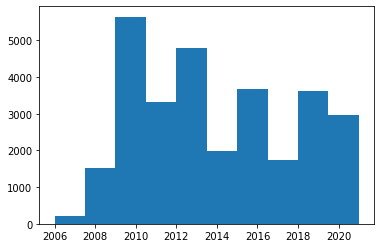

In [677]:
plt.hist(train['registered_year'].values), np.mean(train['registered_year'].values)

In [960]:
fuid

67819

In [961]:
def load_g_mean(a: np.array) -> dict:
    return {x:y for x,y in a}

def calc_g_mean(uids: pd.DataFrame, groups: pd.DataFrame, prior:float=35, alfa:float=10) -> dict:
    g_sum = defaultdict(float)
    g_count = defaultdict(float)
    uid2age = {u:a for u,a in zip(uids['uid'].values, uids['age'].values)}
    for uid, guid in zip(groups['uid'].values, groups['gid'].values):
        g_sum[guid] += uid2age[uid]
        g_count[guid] += 1
    g_mean = dict()
    for g in g_sum.keys():
        g_mean[g] = (prior * alfa + g_sum[g]) / (alfa + g_count[g])
    return g_mean

def calc_g_reg_mean(uids: pd.DataFrame, groups: pd.DataFrame, prior:float=2014, alfa:float=10) -> dict:
    g_sum = defaultdict(float)
    g_count = defaultdict(float)
    uid2reg = {u:a for u,a in zip(uids['uid'].values, uids['registered_year'].values)}
    for uid, guid in zip(groups['uid'].values, groups['gid'].values):
        g_sum[guid] += uid2reg[uid]
        g_count[guid] += 1
    g_mean = dict()
    for g in g_sum.keys():
        g_mean[g] = (prior * alfa + g_sum[g]) / (alfa + g_count[g])
    return g_mean

def calc_f_mean(uids: pd.DataFrame, friends: pd.DataFrame, prior:float=35, alfa:float=10) -> dict:
    f_sum = defaultdict(float)
    f_count = defaultdict(float)
    uid2age = {u:a for u,a in zip(uids['uid'].values, uids['age'].values)}
    for uid, fid in zip(friends['uid'].values, friends['fuid'].values):
        if uid in uid2age:
            f_sum[fid] += uid2age[uid]
            f_count[fid] += 1
        if fid in uid2age:
            f_sum[uid] += uid2age[fid]
            f_count[uid] += 1
    f_mean = dict()
    for f in f_sum.keys():
        f_mean[f] = (prior * alfa + f_sum[f]) / (alfa + f_count[f])
    return f_mean

def calc_f_min(uids: pd.DataFrame, friends: pd.DataFrame, prior:float=35) -> dict:
    f_arr = defaultdict(lambda: [35,])
    uid2age = {u:a for u,a in zip(uids['uid'].values, uids['age'].values)}
    for uid, fid in zip(friends['uid'].values, friends['fuid'].values):
        if uid in uid2age:
            f_arr[fid].append(uid2age[uid])
        if fid in uid2age:
            f_arr[uid].append(uid2age[fid])
    f_mean = dict()
    for f in f_sum.keys():
        f_mean[f] = (prior * alfa + f_sum[f]) / (alfa + f_count[f])
    return f_mean

def calc_f_reg_mean(uids: pd.DataFrame, friends: pd.DataFrame, prior:float=2014, alfa:float=10) -> dict:
    f_sum = defaultdict(float)
    f_count = defaultdict(float)
    uid2reg = {u:a for u,a in zip(uids['uid'].values, uids['registered_year'].values)}
    for uid, fid in zip(friends['uid'].values, friends['fuid'].values):
        if uid in uid2age:
            f_sum[fid] += uid2reg[uid]
            f_count[fid] += 1
        if fid in uid2age:
            f_sum[uid] += uid2reg[fid]
            f_count[uid] += 1
    f_mean = dict()
    for f in f_sum.keys():
        f_mean[f] = (prior * alfa + f_sum[f]) / (alfa + f_count[f])
    return f_mean

def calc_mean_of_mean_of_friends(uids: pd.DataFrame, friends: pd.DataFrame, f_mean: dict) -> dict:
    u2f = dict()
    f_list = defaultdict(list)
    for uid, fid in zip(friends['uid'].values, friends['fuid'].values):
        f_list[uid].append(fid)
        f_list[fid].append(uid)
    for u in f_list.keys():
        verified_friends = [f for f in f_list[u] if f in f_mean]
        if len(verified_friends) == 0:
            continue
        u2f[u] = np.mean([f_mean[v] for v in verified_friends])
    return u2f

def calc_mean_of_mean_of_groups(uids: pd.DataFrame, groups: pd.DataFrame, g_mean: dict) -> dict:
    u2f = dict()
    g_list = defaultdict(list)
    for uid, guid in zip(groups['uid'].values, groups['gid'].values):
        g_list[uid].append(guid)
    for u in g_list.keys():
        verified_groups = [g for g in g_list[u] if g in g_mean]
        if len(verified_groups) == 0:
            continue
        u2f[u] = np.mean([g_mean[v] for v in verified_groups])
    return u2f

In [962]:
g_reg_mean = calc_g_reg_mean(train, groups)
uid2mmg_reg = calc_mean_of_mean_of_groups(train, groups, g_reg_mean)

In [963]:
f_reg_mean = calc_f_reg_mean(train, friends)
uid2mmf_reg = calc_mean_of_mean_of_friends(train, friends, f_reg_mean)

In [964]:
g_mean = calc_g_mean(train, groups)
uid2mmg = calc_mean_of_mean_of_groups(train, groups, g_mean)

In [965]:
f_mean = calc_f_mean(train, friends)
uid2mmf = calc_mean_of_mean_of_friends(train, friends, f_mean)

In [966]:
pd.DataFrame(np.array([[k,v] for k,v in g_mean.items()])).to_csv('../submision/data/g_mean_p35_a10.csv', index=None, index_label=None)
pd.DataFrame(np.array([[k,v] for k,v in f_mean.items()])).to_csv('../submision/data/f_mean_p35_a10.csv', index=None, index_label=None)
pd.DataFrame(np.array([[k,v] for k,v in g_reg_mean.items()])).to_csv('../submision/data/g_reg_mean_p2014_a10.csv', index=None, index_label=None)
pd.DataFrame(np.array([[k,v] for k,v in f_reg_mean.items()])).to_csv('../submision/data/f_reg_mean_p2014_a10.csv', index=None, index_label=None)

In [58]:
def calc_friends_pagerank(friends: pd.DataFrame) -> np.array:
    friends2way = pd.DataFrame()
    friends2way['uid'] = list(friends['uid']) + list(friends['fuid'])
    friends2way['fuid'] = list(friends['fuid']) + list(friends['uid'])
    friend_weights = friends2way.groupby('uid').fuid.nunique()
    friend2weight = {u:w for u,w in zip(friend_weights.index.values, friend_weights.values)}
    rowf = friends2way['fuid'].values
    colf = friends2way['uid'].values
    dataf = [friend2weight[u] for u in colf]
    train_f2u = csr_matrix((dataf, (rowf, colf)), shape=(max(rowf) + 1, max(colf) + 1))
    friend_pr=pagerank_power(train_f2u, p=0.85, tol=1e-3)
    return friend_pr

In [59]:
f = calc_friends_pagerank(friends)

In [60]:
f

array([3.27044627e-06, 2.52198502e-05, 1.34158138e-06, ...,
       1.38165961e-06, 1.34158138e-06, 1.59154157e-05])